In [1]:
# Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, randrange

from scipy.stats import norm # Нормальное распределение для подгонки данных

from sklearn.model_selection import train_test_split, KFold # Два варианта разделения выборки

# Различные алгоритмы
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from lightgbm import Dataset
import xgboost as xgb
from xgboost import DMatrix

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score, f1_score # Меипмкм качества
from sklearn.metrics import roc_curve, precision_recall_curve, RocCurveDisplay, confusion_matrix    # Визуализация результатов

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Data loading
df_main = pd.read_csv('/content/drive/My Drive/HSE/MedAssist_AI/cardio_train.csv', delimiter=';') # Основной датафрейм
df_aux = pd.read_csv('/content/drive/My Drive/HSE/MedAssist_AI/heart.csv', delimiter=',') # Вспомогательный датафрейм для подгонки данных основого

print('main dataframe:')
display(df_main.describe())
print('\n')
print('auxiliary dataframe:')
display(df_aux.describe())

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
main dataframe:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000




auxiliary dataframe:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


В качестве основного датасета был выбран cardio_train. Несмортря на некоторые весьма аномальные столбцы, он содержит достаточное количество данных для обучения более качественных и достоверных моделей. При этом, учитывая выводы, полученные на этапе исследования данных, можно попытаться устранить аномальные значения в столбцах.

# Preprocessing

На первом этапе препроцессинга следует в первую очередь разобраться с аномальными распределениями в данных, поскольку иначе модель рискует потерять интерпретируемость.


В первую очередь достаточное количество аномальных значений содержится в числовых столбцах:

    age (возраст) - планируется сохранить форму нормального распределения, при этом сместив его в область распределения такого же столбца, но из датафрейма heart.csv;
    height (рост) - в столбце имеется часть аномальных значений, их также предполагается подогнать под остальное распредление;
    weigth (вес) - аналогично столбцу роста;
    ap_hi (верхнее давление) и ap_lo - достаточно привести аномальные значения к максимальным/минимальным возможным значениям экспертным оценок.


Среди категориальных столбцов необходимо сделать следующие манипуляции:

    cholesterol (уровень холистерина) - имеет смысл объединить классы 2 и 3 во избежание излишнего дисбаланса. В таком случае новая классификация уровня холистерина будет иметь интерпретацию 1 - нормальный уровень холистерина, 2 - имеются превышения допустимой нормы холистерина;
    gluc (уровень глюкозы) - аналогично холистерину.


## Возраст

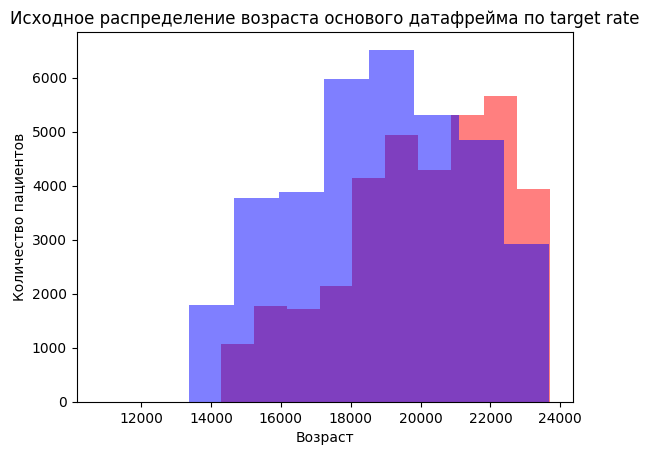

In [2]:
plt.hist(x='age', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='age', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.title('Исходное распределение возраста основого датафрейма по target rate')
plt.show()

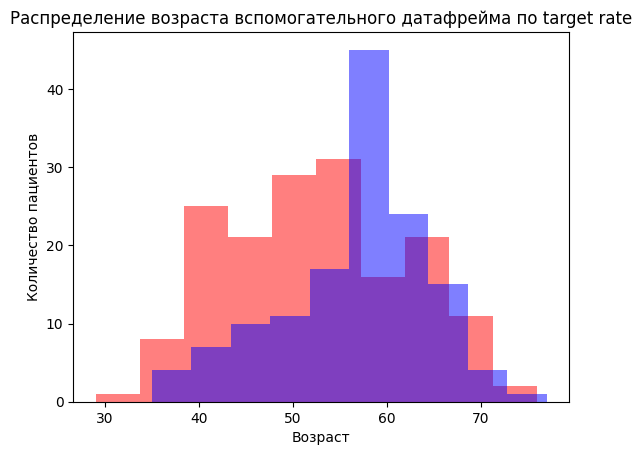

In [3]:
plt.hist(x='age', data=df_aux[df_aux['target']==1], color='r', alpha=0.5)
plt.hist(x='age', data=df_aux[df_aux['target']==0], color='b', alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.title('Распределение возраста вспомогательного датафрейма по target rate')
plt.show()

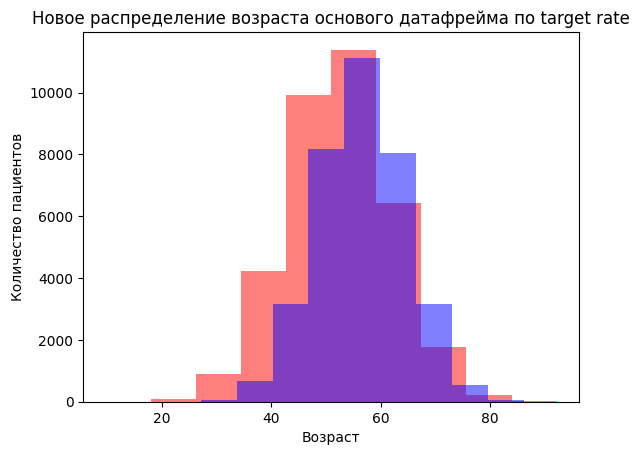

In [4]:
mean_1, std_1 = norm.fit(df_aux[df_aux['target']==1]['age']) # Получение информации о мат. ожидании и СКО из вспомогательного датафрейма
mean_0, std_0 = norm.fit(df_aux[df_aux['target']==0]['age'])
ind_rep_1 = df_main[df_main['cardio']==1].index.tolist()    # Индексы для замены по срезу таргета
ind_rep_0 = df_main[df_main['cardio']==0].index.tolist()

norm_values_1 = norm.rvs(loc=mean_1, scale=std_1, size = len(ind_rep_1))    # Очевидно, что у людей с ССЗ несколько смещённая оценка по возрасту респондентов, потому рассматриваем их отдельно
norm_values_0 = norm.rvs(loc=mean_0, scale=std_0, size = len(ind_rep_0))    # Остальная выборка

df_main.loc[ind_rep_1, 'age'] = norm_values_1
df_main.loc[ind_rep_0, 'age'] = norm_values_0

# Графическая проврека корректности проведённых замен
plt.hist(x='age', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='age', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.title('Новое распределение возраста основого датафрейма по target rate')
plt.show()

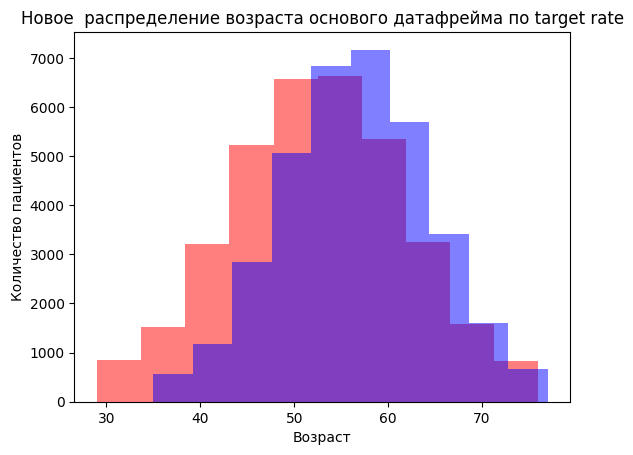

In [5]:
# Оставшиеся аномалии, выходящие за рамки определяемого возраста в выборке df_aux, приводим к максимальным/минимальным значениям по срезам
# max
df_main['age'][(df_main['cardio']==1)*(df_main['age']>max(df_aux['age'][df_aux['target']==1]))] = max(df_aux['age'][df_aux['target']==1])
df_main['age'][(df_main['cardio']==0)*(df_main['age']>max(df_aux['age'][df_aux['target']==0]))] = max(df_aux['age'][df_aux['target']==0])
# min
df_main['age'][(df_main['cardio']==1)*(df_main['age']<min(df_aux['age'][df_aux['target']==1]))] = min(df_aux['age'][df_aux['target']==1])
df_main['age'][(df_main['cardio']==0)*(df_main['age']<min(df_aux['age'][df_aux['target']==0]))] = min(df_aux['age'][df_aux['target']==0])

# Графическая проврека корректности проведённых замен
plt.hist(x='age', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='age', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.title('Новое  распределение возраста основого датафрейма по target rate')
plt.show()

## Рост

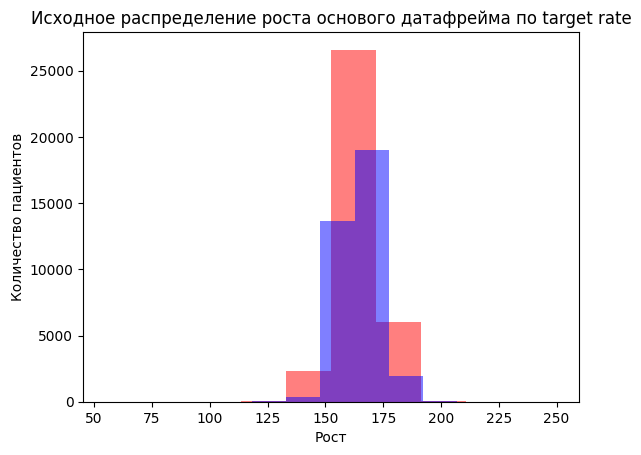

In [6]:
plt.hist(x='height', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='height', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Рост')
plt.ylabel('Количество пациентов')
plt.title('Исходное распределение роста основого датафрейма по target rate')
plt.show()

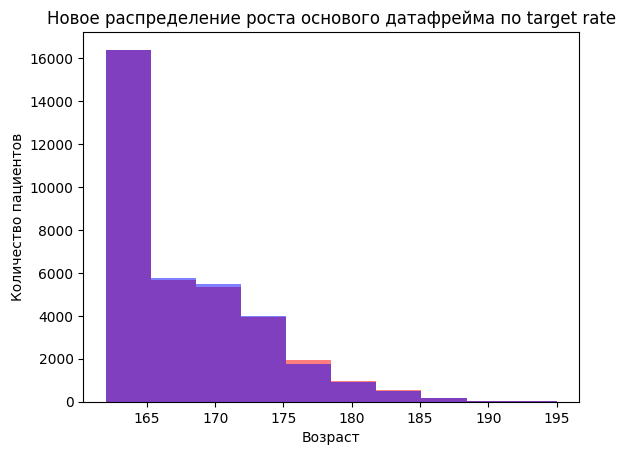

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,54.557132,1.349571,167.567777,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,8.905623,0.476838,5.570158,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,29.000000,1.000000,162.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.626824,1.000000,162.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.750083,1.000000,166.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,60.662430,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,77.000000,2.000000,195.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Аномальные значения роста предполагается подогнать под распределение основной выборки
mean_1, std_1 = norm.fit(df_main[(df_main['cardio']==1)*((df_main['height']>=np.quantile(df_main['height'],0.25))+(df_main['height']<=195))]['height']) # Примем допустимым рост по 1ому квантилю для нижней границы и 195 см для верхней (в распределении роста наблюдается смещение вправо, потому некорретно брать 3ий квантиль)
mean_0, std_0 = norm.fit(df_main[(df_main['cardio']==0)*((df_main['height']>=np.quantile(df_main['height'],0.25))+(df_main['height']<=195))]['height'])

ind_rep_1 = df_main[(df_main['cardio']==1)*((df_main['height']<np.quantile(df_main['height'],0.25))+(df_main['height']>195))].index.tolist()
ind_rep_0 = df_main[(df_main['cardio']==0)*((df_main['height']<np.quantile(df_main['height'],0.25))+(df_main['height']>195))].index.tolist()

norm_values_1 = norm.rvs(loc=mean_1, scale=std_1, size = len(ind_rep_1))
norm_values_0 = norm.rvs(loc=mean_0, scale=std_0, size = len(ind_rep_0))

df_main.loc[ind_rep_1, 'height'] = norm_values_1
df_main.loc[ind_rep_0, 'height'] = norm_values_0

# Оставшиеся после основной замены аномалии просто приведём к квантилям
df_main['height'][(df_main['cardio']==1)*(df_main['height']<np.quantile(df_main['height'],0.25))] = np.quantile(df_main[df_main['cardio']==1]['height'],0.25)
df_main['height'][(df_main['cardio']==0)*(df_main['height']<np.quantile(df_main['height'],0.25))] = np.quantile(df_main[df_main['cardio']==0]['height'],0.25)
df_main['height'][(df_main['cardio']==1)*(df_main['height']>195)] = 195
df_main['height'][(df_main['cardio']==0)*(df_main['height']>195)] = 195

# Графическая проврека корректности проведённых замен
plt.hist(x='height', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='height', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.title('Новое распределение роста основого датафрейма по target rate')
plt.show()

display(df_main.describe())

## Вес

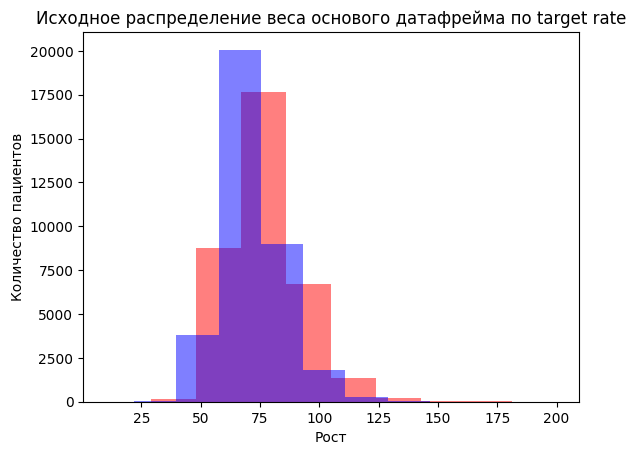

In [8]:
plt.hist(x='weight', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='weight', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Рост')
plt.ylabel('Количество пациентов')
plt.title('Исходное распределение веса основого датафрейма по target rate')
plt.show()

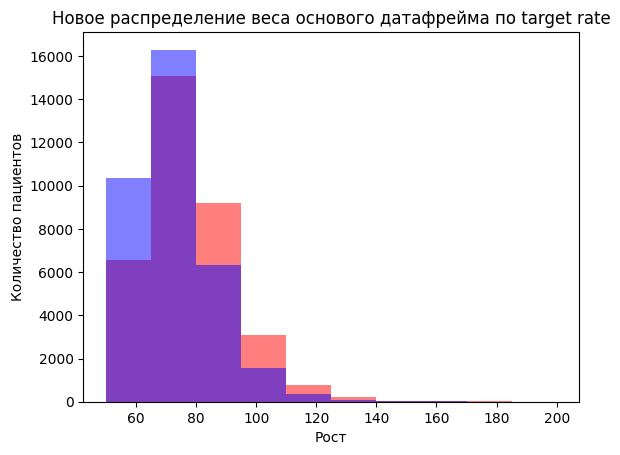

In [9]:
# Больше вес - больше проблем с сердцем, аномалии только слева, приведём их к 50 кило (никакой анарексии, тем более в этой области веса очень мало целевых событий, так что точность тут незначительна)
df_main['weight'][df_main['weight'] < 50] = 50

plt.hist(x='weight', data=df_main[df_main['cardio']==1], color='r', alpha=0.5)
plt.hist(x='weight', data=df_main[df_main['cardio']==0], color='b', alpha=0.5)
plt.xlabel('Рост')
plt.ylabel('Количество пациентов')
plt.title('Новое распределение веса основого датафрейма по target rate')
plt.show()

## Давление

In [10]:
display(df_main[df_main['cardio']==1].describe())
display(df_main[df_main['cardio']==0].describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.0
mean,50082.102233,52.555487,1.353441,167.578650,76.860676,137.212042,109.023929,1.517396,1.277595,0.083736,0.052117,0.789559,1.0
std,28834.739699,9.377397,0.478045,5.603920,14.878470,191.289607,217.805266,0.776355,0.624617,0.276995,0.222266,0.407627,0.0
min,1.000000,29.000000,1.000000,162.000000,50.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,25272.500000,46.140800,1.000000,162.000000,66.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
50%,50115.000000,52.599853,1.000000,166.000000,75.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
75%,75027.500000,58.985393,2.000000,170.177686,85.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.0
max,99998.000000,76.000000,2.000000,195.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.0
mean,49862.869107,56.556377,1.345707,167.556917,71.686310,120.432598,84.251763,1.216527,1.175380,0.092516,0.055424,0.817881,0.0
std,28867.831291,7.918225,0.475605,5.536289,13.124711,103.550672,152.686959,0.526973,0.509611,0.289757,0.228809,0.385948,0.0
min,0.000000,35.000000,1.000000,162.000000,50.000000,-120.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,24716.000000,51.185834,1.000000,162.000000,63.000000,110.000000,70.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
50%,49876.000000,56.604998,1.000000,166.000000,70.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
75%,74729.000000,62.000009,2.000000,170.000000,79.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
max,99999.000000,77.000000,2.000000,195.000000,200.000000,14020.000000,9800.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.0


In [11]:
# Также приведём к максимальным/минимальным экспертным оценкам
df_main['ap_hi'][df_main['ap_hi'] > 200] = 200   # Такое систолическое давление по экспертным оценкам явно является симптомом ССЗ
df_main['ap_hi'][df_main['ap_hi'] < 70] = 70     # Аналогично


df_main['ap_lo'][df_main['ap_lo'] > 110] = 110   # Тоже самое про диастолическое давление
df_main['ap_lo'][df_main['ap_lo'] < 50] = 50

display(df_main[df_main['cardio']==1].describe())
display(df_main[df_main['cardio']==0].describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.000000,34979.0
mean,50082.102233,52.555487,1.353441,167.578650,76.860676,134.190800,85.090683,1.517396,1.277595,0.083736,0.052117,0.789559,1.0
std,28834.739699,9.377397,0.478045,5.603920,14.878470,17.974191,10.027819,0.776355,0.624617,0.276995,0.222266,0.407627,0.0
min,1.000000,29.000000,1.000000,162.000000,50.000000,70.000000,50.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0
25%,25272.500000,46.140800,1.000000,162.000000,66.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
50%,50115.000000,52.599853,1.000000,166.000000,75.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
75%,75027.500000,58.985393,2.000000,170.177686,85.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.0
max,99998.000000,76.000000,2.000000,195.000000,200.000000,200.000000,110.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.000000,35021.0
mean,49862.869107,56.556377,1.345707,167.556917,71.686310,119.568602,78.255675,1.216527,1.175380,0.092516,0.055424,0.817881,0.0
std,28867.831291,7.918225,0.475605,5.536289,13.124711,13.081116,8.429932,0.526973,0.509611,0.289757,0.228809,0.385948,0.0
min,0.000000,35.000000,1.000000,162.000000,50.000000,70.000000,50.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,24716.000000,51.185834,1.000000,162.000000,63.000000,110.000000,70.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
50%,49876.000000,56.604998,1.000000,166.000000,70.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
75%,74729.000000,62.000009,2.000000,170.000000,79.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
max,99999.000000,77.000000,2.000000,195.000000,200.000000,200.000000,110.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.0


## Категориальные признаки

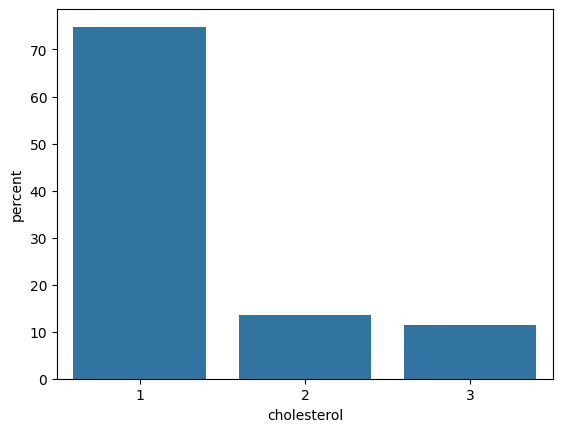

In [12]:
sns.countplot(df_main, x='cholesterol', stat='percent')
plt.show()

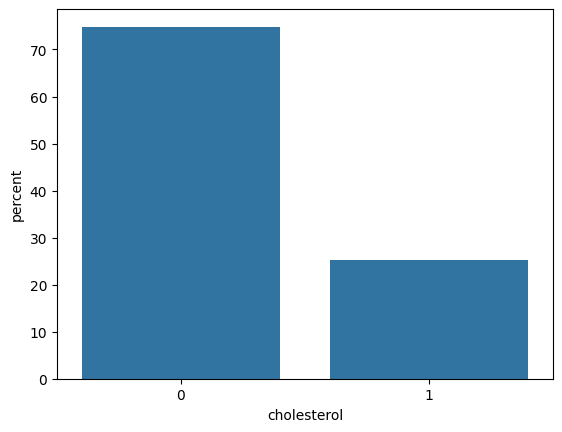

In [13]:
# Объединяем малые классы категориальных признаков
df_main['cholesterol'][df_main['cholesterol']==1] = 0  # Низкий уровень холистерина
df_main['cholesterol'][df_main['cholesterol']>1] = 1  # Повышенный уровень холистерина

sns.countplot(df_main, x='cholesterol', stat='percent')
plt.show()

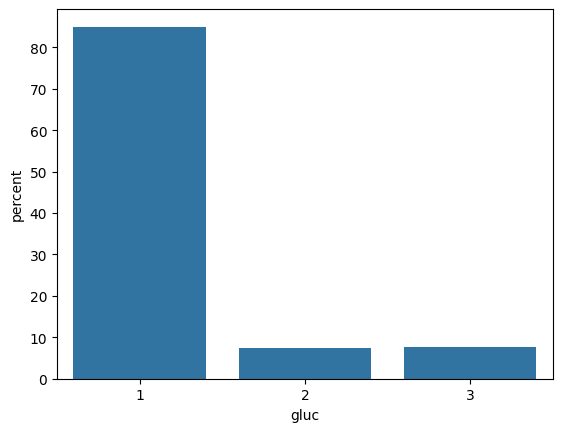

In [14]:
sns.countplot(df_main, x='gluc', stat='percent')
plt.show()

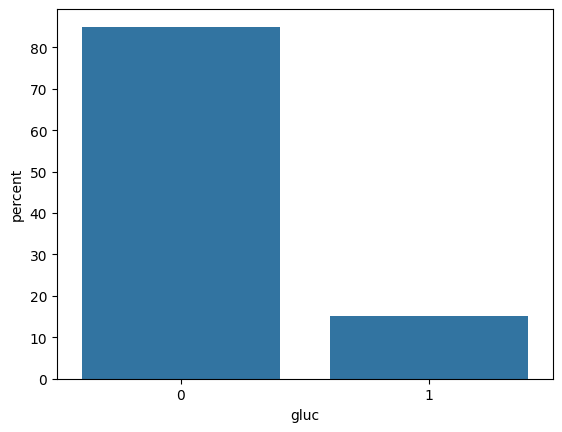

In [15]:
df_main['gluc'][df_main['gluc']==1] = 0  # Низкий уровень глюкозы
df_main['gluc'][df_main['gluc']>1] = 1   # Повышенный уровень глюкозы

sns.countplot(df_main, x='gluc', stat='percent')
plt.show()

In [16]:
# Приведём столбец возраста также к формату [0,1] для единообразия категориальных признаков
df_main['gender'][df_main['gender']==1] = 0     # мужской пол
df_main['gender'][df_main['gender']==2] = 1     # женский пол

In [17]:
df_main.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,54.557132,0.349571,167.567777,74.271941,126.875314,81.671129,0.251643,0.150300,0.088129,0.053771,0.803729,0.499700
std,28851.302323,8.905623,0.476838,5.570158,14.264975,17.334860,9.873190,0.433960,0.357368,0.283484,0.225568,0.397179,0.500003
min,0.000000,29.000000,0.000000,162.000000,50.000000,70.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.626824,0.000000,162.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.750083,0.000000,166.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,60.662430,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,77.000000,1.000000,195.000000,200.000000,200.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Сохраним получившеюся исправленную выборку для дальнейшей работы именно с ней
df_main.to_parquet('/content/drive/My Drive/HSE/MedAssist_AI/cardio_train_correct.parquet')

# Baseline models

In [19]:
# Загрузим корректный датафрей
df = pd.read_parquet('/content/drive/My Drive/HSE/MedAssist_AI/cardio_train_correct.parquet')

df.drop('id', axis=1, inplace=True)
features = df.drop('cardio', axis=1)
target = df['cardio']

# Разделим этот датафрейм на обучающую и тестовые выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=12, stratify=target, test_size=0.2, shuffle=True)
print(f'Размерность обучающего набора данных: {features_train.shape}')
print(f'Размерность тестового набора данных: {features_test.shape}')

Размерность обучающего набора данных: (56000, 11)
Размерность тестового набора данных: (14000, 11)


## Linear baseline

После исправления ошибок в данных первым делом имеет смысл построить самую простую линейную модель. При достаточно высоких показателях метрик, можно с уверенностью сказать, что произведённые манипуляции с данными были уместными.

In [20]:
LR = LogisticRegression().fit(features_train, target_train)

LR_pred = LR.predict(features_test)
LR_prob = LR.predict_proba(features_test)[:,1]

LR_acc = accuracy_score(target_test, LR_pred)
LR_prec = precision_score(target_test, LR_pred)
LR_rec = recall_score(target_test, LR_pred)
LR_f1 = f1_score(target_test, LR_pred)
LR_auc = roc_auc_score(target_test, LR_pred)
LR_kappa = cohen_kappa_score(target_test, LR_pred)

Results = pd.DataFrame({
                            'Algorithm': 'LogisticRegression',
                            'Accuracy': LR_acc,
                            'Precision': LR_prec,
                            'Recall': LR_rec,
                            'F1': LR_f1,
                            'ROC-AUC': LR_auc,
                            'LR_kappa': LR_kappa
                        }, index=[0])
Results

,Algorithm,Accuracy,Precision,Recall,F1,ROC-AUC,LR_kappa
0,LogisticRegression,0.729214,0.749261,0.688536,0.717616,0.729191,0.458403


Модель получилась достаточно качественной. Рассмотрим матрицу ошибок:

<Axes: >

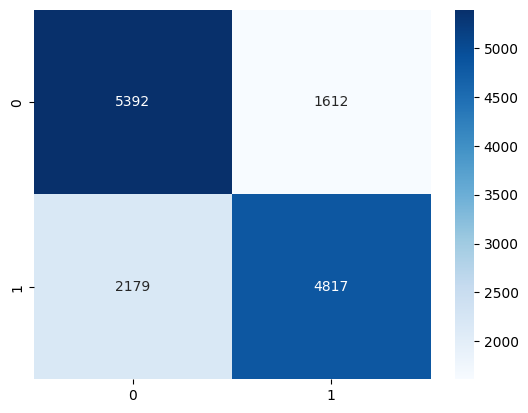

In [21]:
# Матрица ошибок
LR_conf_matrix = confusion_matrix(target_test, LR_pred)
sns.heatmap(LR_conf_matrix, annot=True, cmap= 'Blues', fmt = 'd')

Матрица ошибок показывает некоторое отклонение от истинных значений модели, что однако скорее говорит о хорошем балансе весов логистической регрессии, тк в противном случае встал бы вопрос о переобученности модели.

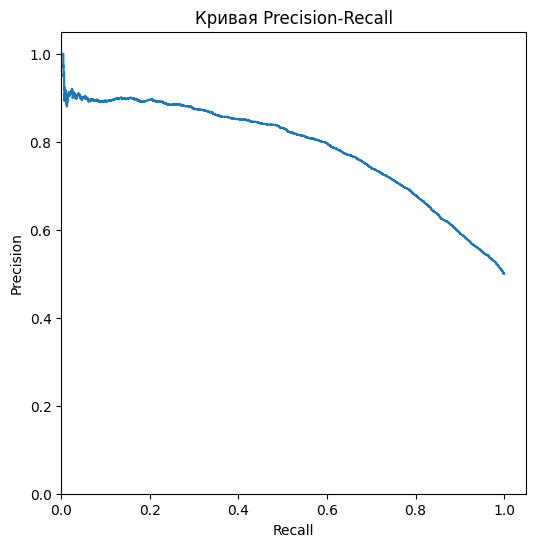

In [22]:
# Кривая Precision-Recall
precision, recall, thresholds = precision_recall_curve(target_test, LR_prob)

plt.figure(figsize=(6,6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.show()

Кривая Precision-Recall также показывает незначительно усечение площади под ней, что как раз и указывает на ложноположительные и ложноотрицательные ответы из матрицы выше.

Было бы интересно перебрать параметр регуляризации и посмотреть, насколько минимальный тюнинг линейной модели отразится на качестве метрик:

In [23]:
# Логистическая регрессия с минимально подогнанной регуляризацией
best_model_LR = None
best_result_LR = 0
best_C = 0
acc_train = []
acc_valid = []
C_reg = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]

for reg in C_reg:
    LR_Mod = LogisticRegression(C=reg, solver='liblinear', max_iter=500, random_state=12, class_weight='balanced')
    LR_Mod.fit(features_train, target_train)
    acc_val = LR_Mod.score(features_test, target_test)
    acc_tr = LR_Mod.score(features_train, target_train)
    if acc_val > best_result_LR:
        best_model_LR = LR_Mod
        best_result_LR = acc_val
        best_C = reg
    acc_valid.append(acc_val)
    acc_train.append(acc_tr)

LR_pred = best_model_LR.predict(features_test)
LR_prob = best_model_LR.predict_proba(features_test)[:,1]

LR_acc = accuracy_score(target_test, LR_pred)
LR_prec = precision_score(target_test, LR_pred)
LR_rec = recall_score(target_test, LR_pred)
LR_f1 = f1_score(target_test, LR_pred)
LR_auc = roc_auc_score(target_test, LR_pred)
LR_kappa = cohen_kappa_score(target_test, LR_pred)

Results = pd.concat([Results, pd.DataFrame({
                                            'Algorithm': 'LogisticRegression Modified',
                                            'Accuracy': LR_acc,
                                            'Precision': LR_prec,
                                            'Recall': LR_rec,
                                            'F1': LR_f1,
                                            'ROC-AUC': LR_auc,
                                            'LR_kappa': LR_kappa
                                        }, index=[0])]
                    )
Results

,Algorithm,Accuracy,Precision,Recall,F1,ROC-AUC,LR_kappa
0,LogisticRegression,0.729214,0.749261,0.688536,0.717616,0.729191,0.458403
0,LogisticRegression Modified,0.733000,0.754770,0.689823,0.720836,0.732975,0.465974


Удалось незначительно улучшить модель.

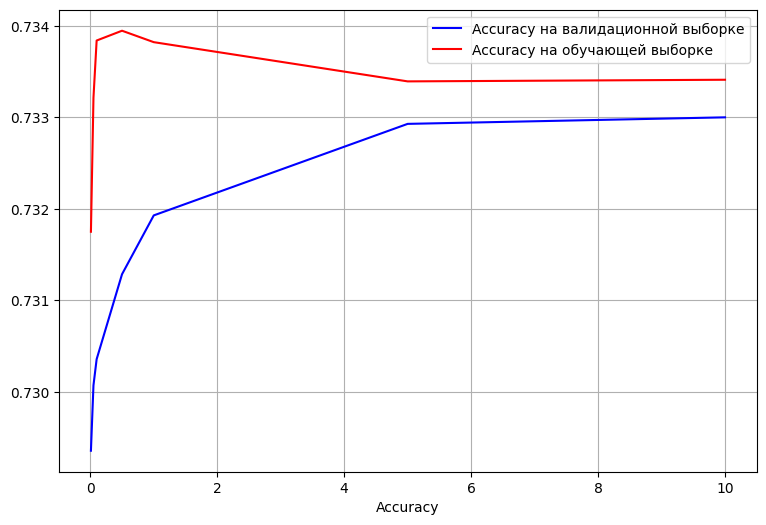

In [24]:
plt.figure(figsize=(9,6))

plt.plot(C_reg, acc_valid, 'b')
plt.plot(C_reg, acc_train, 'r')

plt.xlabel('Глубина регуляризации')
plt.xlabel('Accuracy')
plt.grid()
plt.legend(['Accuracy на валидационной выборке', 'Accuracy на обучающей выборке'])

plt.show()

С помощью простого перебора параметра регуляризации удалось улучшить и без того неплохую логистическую модель. Очевидно, что модели градиентонго бустинга должны показать ещё лучший результат.

## Gradient boostings baselines

В случае с таким объёмом данных (70 тысяч сэмплов) гораздо более воспроизводимы для данного проекта будут вариации алгоритма градиентного бустинга. Попробуем 3 популярных варианта:

### LightGBM_Classifier

In [25]:
import lightgbm as lgb
params = {
            'boosting_type': 'gbdt',
            'objective': ['binary'],
            'metric': 'accuracy',
            'max_depth': 5,
            'num_leaves': 2**5,
            'min_child_samples': 2_000,
            'colsample_bytree': 0.8,
            'subsample': 0.8,
            'subsample_freq': 5,
            'verbose': -1,
            'n_jobs': -1,
            'n_estimators': 10_000,
            'importance_type': 'gain',
            'is_unbalance': False,
            '-DUSE_CUDA': 1
        }
train_data = Dataset(features_train, label=target_train)
val_data = Dataset(features_test, label=target_test)
LGB = lgb.train(params, train_data, num_boost_round=100, valid_sets=[val_data])
LGB_prob = LGB.predict(features_test)
LGB_pred = LGB.predict(features_test).round()

LGB_acc = accuracy_score(target_test, LGB_pred)
LGB_prec = precision_score(target_test, LGB_pred)
LGB_rec = recall_score(target_test, LGB_pred)
LGB_f1 = f1_score(target_test, LGB_pred)
LGB_auc = roc_auc_score(target_test, LGB_pred)
LGB_kappa = cohen_kappa_score(target_test, LGB_pred)

Results = pd.concat([Results, pd.DataFrame({
                                            'Algorithm': 'Lightgbm Baseline',
                                            'Accuracy': LGB_acc,
                                            'Precision': LGB_prec,
                                            'Recall': LGB_rec,
                                            'F1': LGB_f1,
                                            'ROC-AUC': LGB_auc,
                                            'LR_kappa': LGB_kappa
                                        }, index=[0])]
                    )
Results

,Algorithm,Accuracy,Precision,Recall,F1,ROC-AUC,LR_kappa
0,LogisticRegression,0.729214,0.749261,0.688536,0.717616,0.729191,0.458403
0,LogisticRegression Modified,0.733000,0.754770,0.689823,0.720836,0.732975,0.465974
0,Lightgbm Baseline,0.728571,0.745619,0.693396,0.718560,0.728551,0.457121


In [26]:
import lightgbm as lgb

params = {
            'boosting_type': 'gbdt',
            'objective': ['binary'],
            'metric': 'accuracy',
            'max_depth': 5,
            'num_leaves': 2**5,
            'min_child_samples': 2_000,
            'colsample_bytree': 0.8,
            'subsample': 0.8,
            'subsample_freq': 5,
            'verbose': -1,
            'n_jobs': -1,
            'n_estimators': 10_000,
            'importance_type': 'gain',
            'is_unbalance': False,
            '-DUSE_CUDA': 1
        }

# Инициализация KFold
kf = KFold(n_splits=4)
oof_predictions = np.zeros(target.shape)

# Обучение модели с out-of-fold
for train_index, val_index in kf.split(features):
    X_train, X_val = features.iloc[train_index], features.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]

    train_data = Dataset(X_train, label=y_train)
    val_data = Dataset(X_val, label=y_val)

    LGB_OOF = lgb.train(params, train_data, num_boost_round=100, valid_sets=[val_data])

    oof_predictions[val_index] = LGB_OOF.predict(X_val, num_iteration=LGB_OOF.best_iteration).round()

# Оценка модели
accuracy = np.mean(oof_predictions == target)
print(f'Out-of-Fold accuracy: {accuracy:.4f}')


Out-of-Fold accuracy: 0.7306


### Catboost Classifier

In [27]:
CB = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=3, loss_function='Logloss', eval_metric='AUC', random_seed=12)
train_pool = Pool(features_train, label=target_train)
val_pool = Pool(features_test, label=target_test)
CB.fit(train_pool, eval_set=val_pool)

CB_prob = CB.predict_proba(features_test)[:,1]
CB_pred = CB.predict(features_test)

CB_acc = accuracy_score(target_test, CB_pred)
CB_prec = precision_score(target_test, CB_pred)
CB_rec = recall_score(target_test, CB_pred)
CB_f1 = f1_score(target_test, CB_pred)
CB_auc = roc_auc_score(target_test, CB_pred)
CB_kappa = cohen_kappa_score(target_test, CB_pred)

Results = pd.concat([Results, pd.DataFrame({
                                            'Algorithm': 'CatBoost Baseline',
                                            'Accuracy': CB_acc,
                                            'Precision': CB_prec,
                                            'Recall': CB_rec,
                                            'F1': CB_f1,
                                            'ROC-AUC': CB_auc,
                                            'LR_kappa': CB_kappa
                                        }, index=[0])]
                    )
Results

0:	test: 0.7649501	best: 0.7649501 (0)	total: 59ms	remaining: 29.4s
1:	test: 0.7741973	best: 0.7741973 (1)	total: 70.9ms	remaining: 17.7s
2:	test: 0.7835905	best: 0.7835905 (2)	total: 81.6ms	remaining: 13.5s
3:	test: 0.7845431	best: 0.7845431 (3)	total: 93.3ms	remaining: 11.6s
4:	test: 0.7865206	best: 0.7865206 (4)	total: 110ms	remaining: 10.9s
5:	test: 0.7866215	best: 0.7866215 (5)	total: 137ms	remaining: 11.3s
6:	test: 0.7865949	best: 0.7866215 (5)	total: 150ms	remaining: 10.6s
7:	test: 0.7871251	best: 0.7871251 (7)	total: 161ms	remaining: 9.89s
8:	test: 0.7881071	best: 0.7881071 (8)	total: 172ms	remaining: 9.4s
9:	test: 0.7891434	best: 0.7891434 (9)	total: 184ms	remaining: 9.01s
10:	test: 0.7901514	best: 0.7901514 (10)	total: 195ms	remaining: 8.67s
11:	test: 0.7913494	best: 0.7913494 (11)	total: 207ms	remaining: 8.43s
12:	test: 0.7931544	best: 0.7931544 (12)	total: 218ms	remaining: 8.18s
13:	test: 0.7941399	best: 0.7941399 (13)	total: 230ms	remaining: 7.98s
14:	test: 0.7942750	best:

,Algorithm,Accuracy,Precision,Recall,F1,ROC-AUC,LR_kappa
0,LogisticRegression,0.729214,0.749261,0.688536,0.717616,0.729191,0.458403
0,LogisticRegression Modified,0.733000,0.754770,0.689823,0.720836,0.732975,0.465974
0,Lightgbm Baseline,0.728571,0.745619,0.693396,0.718560,0.728551,0.457121
0,CatBoost Baseline,0.739286,0.768109,0.685106,0.724237,0.739255,0.478539


In [28]:
# Инициализация CatBoostClassifier
CB_OOF = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=3, loss_function='Logloss', eval_metric='Accuracy', random_seed=12)

# Инициализация KFold
kf = KFold(n_splits=4)
oof_predictions = np.zeros(target.shape)

# Обучение модели с out-of-fold
for train_index, val_index in kf.split(features):
    X_train, X_val = features.iloc[train_index], features.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]

    # Создание Pool для CatBoost
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)

    CB_OOF.fit(train_pool, eval_set=val_pool, verbose=0)

    oof_predictions[val_index] = CB_OOF.predict(X_val)

# Оценка модели
accuracy = np.mean(oof_predictions == target)
print(f'Out-of-Fold Accuracy: {accuracy:.4f}')

Out-of-Fold Accuracy: 0.7415


В виду достаточно однородных результатов по метрикам моделей, не имеет смысла тестировать также XGBoost, его вполне можно отложить на улучшение качество модели и создание ансамблей. Отмечу лишь, что данный варианта алгоритма градиентного бустинга прекрасно подходит именно под варианты с весьма ограниченной выборкой.

### XGBoost

In [29]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 10000,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 5,
    'verbosity': 0,
    'n_jobs': -1,
    'importance_type': 'weight'
        }

train_data = xgb.DMatrix(features_train, label=target_train)
val_data = xgb.DMatrix(features_test, label=target_test)

XGB = xgb.train(params, train_data, num_boost_round=100, evals=[(val_data, 'validation')])

XGB_prob = XGB.predict(val_data)
XGB_pred = (XGB_prob > 0.5).astype(int)

XGB_acc = accuracy_score(target_test, XGB_pred)
XGB_prec = precision_score(target_test, XGB_pred)
XGB_rec = recall_score(target_test, XGB_pred)
XGB_f1 = f1_score(target_test, XGB_pred)
XGB_auc = roc_auc_score(target_test, XGB_pred)
XGB_kappa = cohen_kappa_score(target_test, XGB_pred)

Results = pd.concat([Results, pd.DataFrame({
                                            'Algorithm': 'XGBoost Baseline',
                                            'Accuracy': XGB_acc,
                                            'Precision': XGB_prec,
                                            'Recall': XGB_rec,
                                            'F1': XGB_f1,
                                            'ROC-AUC': XGB_auc,
                                            'LR_kappa': XGB_kappa
                                        }, index=[0])]
                    )
Results

[0]	validation-logloss:0.67041
[1]	validation-logloss:0.64940
[2]	validation-logloss:0.63136
[3]	validation-logloss:0.62588
[4]	validation-logloss:0.61178
[5]	validation-logloss:0.60003
[6]	validation-logloss:0.59573
[7]	validation-logloss:0.58958
[8]	validation-logloss:0.58354
[9]	validation-logloss:0.57715
[10]	validation-logloss:0.57158
[11]	validation-logloss:0.56756
[12]	validation-logloss:0.56374
[13]	validation-logloss:0.55976
[14]	validation-logloss:0.55619
[15]	validation-logloss:0.55379
[16]	validation-logloss:0.55123
[17]	validation-logloss:0.54906
[18]	validation-logloss:0.54719
[19]	validation-logloss:0.54633
[20]	validation-logloss:0.54494
[21]	validation-logloss:0.54442
[22]	validation-logloss:0.54358
[23]	validation-logloss:0.54250
[24]	validation-logloss:0.54173
[25]	validation-logloss:0.54125
[26]	validation-logloss:0.54057
[27]	validation-logloss:0.53986
[28]	validation-logloss:0.53946
[29]	validation-logloss:0.53905
[30]	validation-logloss:0.53872
[31]	validation-lo

,Algorithm,Accuracy,Precision,Recall,F1,ROC-AUC,LR_kappa
0,LogisticRegression,0.729214,0.749261,0.688536,0.717616,0.729191,0.458403
0,LogisticRegression Modified,0.733000,0.754770,0.689823,0.720836,0.732975,0.465974
0,Lightgbm Baseline,0.728571,0.745619,0.693396,0.718560,0.728551,0.457121
0,CatBoost Baseline,0.739286,0.768109,0.685106,0.724237,0.739255,0.478539
0,XGBoost Baseline,0.741857,0.769697,0.689823,0.727574,0.741827,0.483684


In [30]:
# Инициализация XGBClassifier с поддержкой GPU
XGB_OOF = xgb.XGBClassifier(
                            n_estimators=500,
                            learning_rate=0.1,
                            max_depth=3,
                            objective='binary:logistic',
                            eval_metric='logloss',
                            random_state=12
                          )

# Инициализация KFold
kf = KFold(n_splits=4)
oof_predictions = np.zeros(target.shape)

for train_index, val_index in kf.split(features):
    X_train, X_val = features.iloc[train_index], features.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]

    XGB_OOF.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    oof_predictions[val_index] = XGB_OOF.predict(X_val)

# Оценка модели
accuracy = np.mean(oof_predictions == target)
print(f'Out-of-Fold Accuracy: {accuracy:.4f}')


Out-of-Fold Accuracy: 0.7397


Финальная таблица сравнения метрик:
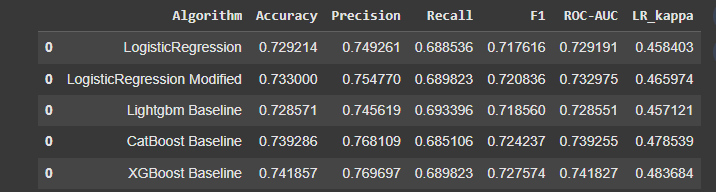

Более подходящей под данную задачу является модель XGBoost в виду более высокой устойчивости к переобучению на ограниченном источнике данных.

Именно это модель можно признать основной для бэйзлайна.

## Сохранение моделей

In [32]:
# Сохранение моделей
import joblib # т.к. модель строится на больших массивах данных, имеет смысл использовать библиотеку joblib
# linear
LR_file = "/content/drive/My Drive/HSE/MedAssist_AI/logistic_regression_simple.pkl"
LR_mod_file = "/content/drive/My Drive/HSE/MedAssist_AI/logistic_regression_modified.pkl"
# lightgbm
LGB_file = "/content/drive/My Drive/HSE/MedAssist_AI/lightgb_simple.pkl"
LGB_OOF_file = "/content/drive/My Drive/HSE/MedAssist_AI/lightgb_oof.pkl"
# catboost
CB_file = "/content/drive/My Drive/HSE/MedAssist_AI/catboost_simple.pkl"
CB_OOF_file = "/content/drive/My Drive/HSE/MedAssist_AI/catboost_oof.pkl"
# xgboost
XGB_file = "/content/drive/My Drive/HSE/MedAssist_AI/xgb_simple.pkl"
XGB_OOF_file = "/content/drive/My Drive/HSE/MedAssist_AI/xgb_oof.pkl"

joblib.dump(LR, LR_file)
joblib.dump(LR_Mod, LR_mod_file)
joblib.dump(LGB, LGB_file)
joblib.dump(LGB_OOF, LGB_OOF_file)
joblib.dump(CB, CB_file)
joblib.dump(CB_OOF, CB_OOF_file)
joblib.dump(XGB, XGB_file)
joblib.dump(XGB_OOF, XGB_OOF_file)

['/content/drive/My Drive/HSE/MedAssist_AI/xgb_oof.pkl']